# 5.1 딥러닝이 푼 첫 문제 이미지 분류

작성자: [김찬란](https://github.com/seriousran)

## 5.1.1 잘 차려진 밥상에 숟가락 얹기 - 미세조정

In [0]:
# 코드 5-1 데이터 생성기 및 세 모델 인스턴스 생성

import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import keras.backend as K
from keras.applications.resnet_v2 import ResNet50V2
from keras.datasets import cifar100
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, Input, Flatten, Dense, Conv2D, Dropout, subtract, maximum, MaxPooling2D, Lambda
from keras.models import Model, clone_model
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, save_img
from keras.optimizers import Adam
from keras.regularizers import l2

from google.colab import drive

drive.mount('/content/drive')

CLASS_NUM = 17
BATCH_SIZE = 16
EPOCHS = 14
INPUT_SHAPE = (224,224,3)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        "/content/drive/My Drive/0_colab/oxford-flowers-17",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset="training",
        shuffle=True)

validation_generator = train_datagen.flow_from_directory(
        "/content/drive/My Drive/0_colab/oxford-flowers-17",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset="validation",
        shuffle=True)

Found 1224 images belonging to 17 classes.
Found 136 images belonging to 17 classes.


In [0]:
base_model_1 = ResNet50V2(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model_2 = ResNet50V2(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model_3 = ResNet50V2(include_top=False, weights='imagenet', input_shape = (224,224,3))













94674944/94668760 [==============================] - 1s 0us/step


In [0]:
# 코드 5-2 트랜스퍼 러닝 모델 생성 함수-1

def create_model(base_model):
  resnet = base_model.get_output_at(0)
  dropout = Dropout(0.3)(resnet)
  y = Flatten()(dropout) # 중간에 dense layer추가한 것도 해보자
  outputs = Dense(CLASS_NUM,
                  activation='softmax',
                  kernel_initializer='he_normal',
                  name='classification_layer')(y)
                  
  model = Model(base_model.get_input_at(0), outputs=outputs)
  return model

model_1 = create_model(base_model_1)

model_1.trainable = True

set_trainable = False
for layer in model_1.layers:
    if layer.name == 'classification_layer':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# 코드 5-3 모델 컴파일 및 학습

model_1.compile(loss='categorical_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['accuracy'])

history_1 = model_1.fit_generator(generator=train_generator,
                                  validation_data=validation_generator,
                                  epochs=EPOCHS, verbose=1,)
                                  #callbacks=callbacks)

Epoch 1/14
77/77 [==============================] - 12s 159ms/step - loss: 5.9191 - acc: 0.5235 - val_loss: 6.7624 - val_acc: 0.5221
Epoch 2/14
77/77 [==============================] - 8s 99ms/step - loss: 3.6850 - acc: 0.7321 - val_loss: 5.7353 - val_acc: 0.6029
Epoch 3/14
77/77 [==============================] - 9s 111ms/step - loss: 3.3877 - acc: 0.7727 - val_loss: 6.6746 - val_acc: 0.5441
Epoch 4/14
77/77 [==============================] - 8s 110ms/step - loss: 3.3239 - acc: 0.7800 - val_loss: 7.0205 - val_acc: 0.4926
Epoch 5/14
77/77 [==============================] - 9s 111ms/step - loss: 3.1458 - acc: 0.7938 - val_loss: 6.9381 - val_acc: 0.5221
Epoch 6/14
77/77 [==============================] - 9s 112ms/step - loss: 3.1631 - acc: 0.7930 - val_loss: 6.9673 - val_acc: 0.5147
Epoch 7/14
77/77 [==============================] - 9s 111ms/step - loss: 3.0408 - acc: 0.8052 - val_loss: 6.3738 - val_acc: 0.5662
Epoch 8/14
77/77 [==============================] - 9s 111ms/step - loss: 2.

In [0]:
# 코드 5-4 트랜스퍼 러닝 모델 생성 및 학습-2

model_2 = create_model(base_model_2)
model_3 = create_model(base_model_3)

for layer in model_2.layers[0:16]:
    layer.trainable=True
for layer in model_2.layers[16:]:
    layer.trainable=False

for layer in model_3.layers[0:176]:
    layer.trainable=False
for layer in model_3.layers[176:]:
    layer.trainable=True

for model in [model_2, model_3]:
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics=['accuracy'])

In [0]:
history_2 = model_2.fit_generator(generator=train_generator,
                                  validation_data=validation_generator,
                                  epochs=EPOCHS, verbose=1,)
                                  #callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/14
77/77 [==============================] - 14s 183ms/step - loss: 4.5458 - acc: 0.0804 - val_loss: 4.6430 - val_acc: 0.0662
Epoch 2/14
77/77 [==============================] - 8s 106ms/step - loss: 4.6526 - acc: 0.0787 - val_loss: 4.4923 - val_acc: 0.0441
Epoch 3/14
77/77 [==============================] - 9s 115ms/step - loss: 4.4174 - acc: 0.0820 - val_loss: 5.1108 - val_acc: 0.0515
Epoch 4/14
77/77 [==============================] - 9s 114ms/step - loss: 4.2665 - acc: 0.0966 - val_loss: 5.3222 - val_acc: 0.0809
Epoch 5/14
77/77 [==============================] - 9s 113ms/step - loss: 4.2821 - acc: 0.0869 - val_loss: 8.0127 - val_acc: 0.0662
Epoch 6/14
77/77 [==============================] - 9s 115ms/step - loss: 4.1567 - acc: 0.0933 - val_loss: 8.9771 - val_acc: 0.0662
Epoch 7/14
77/77 [==============================] - 9s 117ms/step - loss: 4.0610 - acc: 0.1161 - val_loss: 11.49

In [0]:
history_3 = model_3.fit_generator(generator=train_generator,
                                  validation_data=validation_generator,
                                  epochs=EPOCHS, verbose=1,)
                                  #callbacks=callbacks)

Epoch 1/14
77/77 [==============================] - 13s 166ms/step - loss: 2.0593 - acc: 0.6242 - val_loss: 2.2976 - val_acc: 0.6397
Epoch 2/14
77/77 [==============================] - 8s 102ms/step - loss: 0.3532 - acc: 0.9262 - val_loss: 2.0403 - val_acc: 0.7059
Epoch 3/14
77/77 [==============================] - 9s 111ms/step - loss: 0.5245 - acc: 0.9123 - val_loss: 2.6033 - val_acc: 0.6397
Epoch 4/14
77/77 [==============================] - 8s 110ms/step - loss: 0.3133 - acc: 0.9456 - val_loss: 2.8489 - val_acc: 0.6397
Epoch 5/14
77/77 [==============================] - 8s 109ms/step - loss: 0.4227 - acc: 0.9408 - val_loss: 5.3430 - val_acc: 0.5956
Epoch 6/14
77/77 [==============================] - 9s 111ms/step - loss: 0.4348 - acc: 0.9310 - val_loss: 2.5175 - val_acc: 0.7132
Epoch 7/14
77/77 [==============================] - 9s 112ms/step - loss: 0.6355 - acc: 0.9237 - val_loss: 4.1008 - val_acc: 0.6397
Epoch 8/14
77/77 [==============================] - 9s 111ms/step - loss: 0

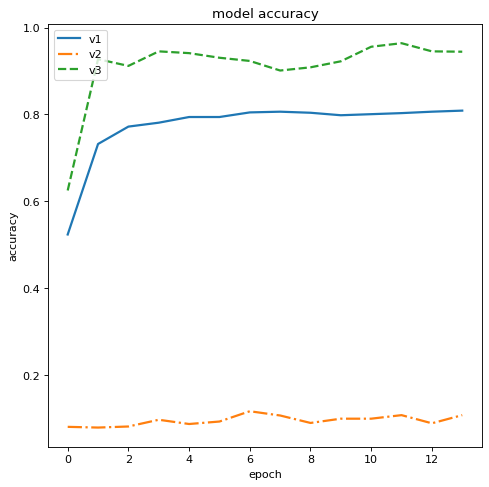

In [0]:
# 코드 5-5 트랜스퍼 러닝 모델 성승 비교 그래프

plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history_1.history['acc'][:14], '-', linewidth=2) 
plt.plot(history_2.history['acc'][:14], '-.', linewidth=2) 
plt.plot(history_3.history['acc'][:14], '--', linewidth=2) 
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['v1', 'v2', 'v3'], loc='upper left')  
plt.show()

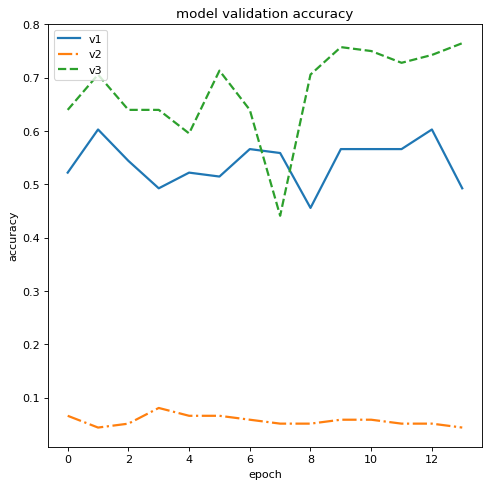

In [0]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history_1.history['val_acc'][:14], '-', linewidth=2) 
plt.plot(history_2.history['val_acc'][:14], '-.', linewidth=2) 
plt.plot(history_3.history['val_acc'][:14], '--', linewidth=2) 
plt.title('model validation accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['v1', 'v2', 'v3'], loc='upper left')  
plt.show()

## 5.1.2. 데이터를 증강하여 강인한 모델

In [0]:
# 코드 5-6 이미지 데이터 생성기를 활용한 데이터 증강

train_aug_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.1,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# 코드 5-7 Cutout random erasing 함수

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
        break

    if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
      c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser

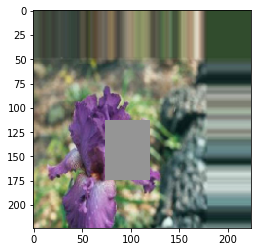

In [0]:
#plt.imshow(img)

In [0]:
# 코드 5-8 사용자 정의 전처리 함수를 포함한 데이터 증강

train_aug_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.1,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=False,
  fill_mode='nearest',
  preprocessing_function = get_random_eraser(v_l=0, v_h=255),
)

Found 1224 images belonging to 17 classes.
Found 136 images belonging to 17 classes.
